<a href="https://colab.research.google.com/github/OTN-Rajapaksha/Naval-Hybrid-Model-Work-In-The-Stock-Market-And-Crypto-Market-Prediction/blob/main/Using_Crude_oil_Dataset_Find_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load crude oil dataset
df_oil = pd.read_csv('/content/crude_oil_2018_2025.csv')
print(f"Crude Oil Dataset Shape: {df_oil.shape}")
print(f"Columns: {list(df_oil.columns)}")
print(f"\nFirst 3 rows:")
print(df_oil.head(3))
print(f"\nMissing values: {df_oil.isnull().sum().sum()}")

Crude Oil Dataset Shape: (1763, 6)
Columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']

First 3 rows:
        Price               Close              High                 Low  \
0      Ticker                CL=F              CL=F                CL=F   
1        Date                 NaN               NaN                 NaN   
2  2018-01-02  60.369998931884766  60.7400016784668  60.099998474121094   

                Open  Volume  
0               CL=F    CL=F  
1                NaN     NaN  
2  60.20000076293945  510313  

Missing values: 5


In [3]:
def preprocess_oil_data(df):
  """
  Preprocesses the crude oil dataset.

  Args:
    df: pandas DataFrame containing crude oil data.

  Returns:
    A tuple containing the preprocessed DataFrame and the name of the price column.
  """
  # Remove the first two rows which appear to be metadata
  df = df.iloc[2:].copy()

  # Convert 'Date' column to datetime
  df['Price'] = pd.to_datetime(df['Price'])

  # Rename 'Price' column to 'Date'
  df = df.rename(columns={'Price': 'Date'})

  # Convert relevant columns to numeric, coercing errors
  numeric_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
  for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

  # Drop rows with missing values after conversion
  df.dropna(inplace=True)

  # Set 'Date' as index
  df.set_index('Date', inplace=True)

  # Assuming 'Close' is the price column for prediction
  price_col = 'Close'

  return df, price_col

In [4]:
print("\n🔧 STEP 2: PREPROCESSING CRUDE OIL DATA")
print("="*50)

# Preprocess crude oil data
print("Starting crude oil data preprocessing...")
oil_clean, oil_price_col = preprocess_oil_data(df_oil.copy())
print(f"✅ Crude oil data preprocessing completed!")
print(f"Final dataset shape: {oil_clean.shape}")
print(f"Price column: {oil_price_col}")
display(oil_clean.head())


🔧 STEP 2: PREPROCESSING CRUDE OIL DATA
Starting crude oil data preprocessing...
✅ Crude oil data preprocessing completed!
Final dataset shape: (1761, 5)
Price column: Close


,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,60.369999,60.740002,60.099998,60.200001,510313
2018-01-03,61.630001,61.970001,60.279999,60.389999,673859
2018-01-04,62.009998,62.209999,61.590000,61.959999,654363
2018-01-05,61.439999,62.040001,61.090000,61.900002,563036
2018-01-08,61.730000,61.970001,61.340000,61.610001,616474


In [7]:
print("\n📈 STEP 3: PREPARING FEATURES FOR ML MODELS - CRUDE OIL")
print("="*50)

def prepare_oil_features(df_clean):
    """Prepare features for crude oil prediction"""

    # First, check if target_price exists, if not create it
    if 'target_price' not in df_clean.columns:
        print("Creating target_price column for crude oil...")
        df_clean['target_price'] = df_clean['Close'].shift(-1)
        # Remove rows with NaN values
        df_clean = df_clean.dropna()
        print(f"New shape after creating target: {df_clean.shape}")

    # Select feature columns (exclude target but include all technical indicators)
    feature_columns = [col for col in df_clean.columns if col != 'target_price']
    print(f"Using {len(feature_columns)} features for crude oil prediction")

    X = df_clean[feature_columns].values
    y = df_clean['target_price'].values

    # Split data (80% train, 20% test)
    split_idx = int(len(X) * 0.8)

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    print(f"Training dates: {df_clean.index[0]} to {df_clean.index[split_idx-1]}")
    print(f"Test dates: {df_clean.index[split_idx]} to {df_clean.index[-1]}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns

# Prepare features for crude oil
X_train_oil, X_test_oil, y_train_oil, y_test_oil, scaler_oil, feature_columns_oil = prepare_oil_features(oil_clean)
print("✅ Crude oil feature preparation completed!")


📈 STEP 3: PREPARING FEATURES FOR ML MODELS - CRUDE OIL
Creating target_price column for crude oil...
New shape after creating target: (1760, 6)
Using 5 features for crude oil prediction
Training set: (1408, 5)
Test set: (352, 5)
Training dates: 2018-01-02 00:00:00 to 2023-08-07 00:00:00
Test dates: 2023-08-08 00:00:00 to 2024-12-30 00:00:00
✅ Crude oil feature preparation completed!


In [8]:
print("\n🤖 STEP 4: DEFINING MACHINE LEARNING MODELS FOR CRUDE OIL")
print("="*50)

# 1. Artificial Neural Network (ANN)
def create_ann_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 2. Support Vector Machine (SVM)
def create_svm_model():
    return SVR(kernel='rbf', C=1.0, epsilon=0.1)

# 3. Decision Tree
def create_decision_tree():
    return DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)

# 4. Random Forest
def create_random_forest():
    return RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)

# Evaluation function
def calculate_metrics(y_true, y_pred):
    return {
        'R2_Score': r2_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

print("✅ Crude oil models defined successfully!")


🤖 STEP 4: DEFINING MACHINE LEARNING MODELS FOR CRUDE OIL
✅ Crude oil models defined successfully!



🧠 STEP 5A: TRAINING ARTIFICIAL NEURAL NETWORK (ANN) FOR CRUDE OIL
Training Artificial Neural Network (ANN) for crude oil...
ANN Architecture for Crude Oil:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4049.7590 - mae: 60.8317 - val_loss: 5686.9888 - val_mae: 75.0880
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2880.3191 - mae: 50.0393 - val_loss: 1015.8723 - val_mae: 29.5924
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1027.5642 - mae: 26.6026 - val_loss: 439.9213 - val_mae: 18.2807
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 688.7093 - mae: 21.6045 - val_loss: 234.6421 - val_mae: 13.3502
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 410.8987 - mae: 16.0151 - val_loss: 85.5681 - val_mae: 7.7962
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 216.2695 - mae: 11.5394 - val_loss: 95.3974 - val_mae: 9.0257
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 165.9003 - mae: 9.9755 - val_loss: 16.0050 - val_mae: 3.2921
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 116.4934 - mae: 7.7492 - val_loss: 18.3617 - val_mae: 3.7040
Epoch 9/100
36/36 ━━

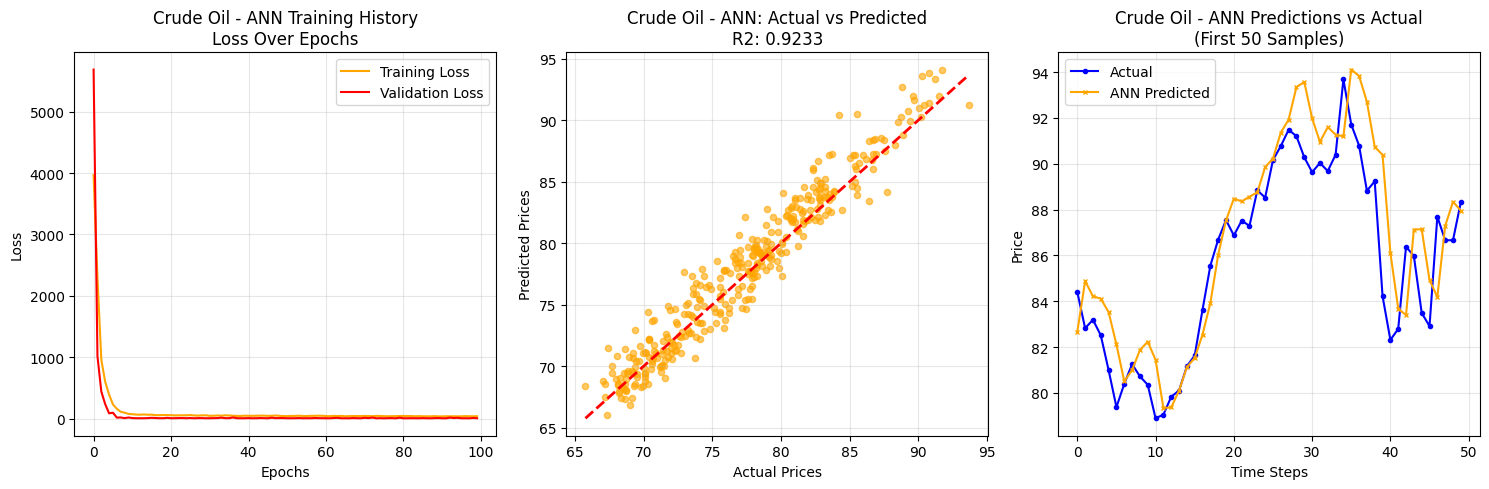


💡 CRUDE OIL - ANN INTERPRETATION:
🎉 EXCELLENT: ANN is highly accurate for crude oil prediction


In [9]:
print("\n🧠 STEP 5A: TRAINING ARTIFICIAL NEURAL NETWORK (ANN) FOR CRUDE OIL")
print("="*60)

import time

# Train ANN on crude oil
print("Training Artificial Neural Network (ANN) for crude oil...")
start_time = time.time()

ann_model_oil = create_ann_model(X_train_oil.shape[1])
print("ANN Architecture for Crude Oil:")
ann_model_oil.summary()

# Train the model
history_oil = ann_model_oil.fit(
    X_train_oil, y_train_oil,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Make predictions
ann_pred_oil = ann_model_oil.predict(X_test_oil).flatten()
ann_time_oil = time.time() - start_time

# Calculate metrics
ann_results_oil = calculate_metrics(y_test_oil, ann_pred_oil)

print(f"\n✅ CRUDE OIL - ANN TRAINING COMPLETED!")
print(f"Training Time: {ann_time_oil:.2f} seconds")
print(f"Epochs: {len(history_oil.history['loss'])}")
print(f"Final Training Loss: {history_oil.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_oil.history['val_loss'][-1]:.4f}")

print(f"\n📊 CRUDE OIL - ANN PERFORMANCE METRICS:")
print(f"R2 Score: {ann_results_oil['R2_Score']:.4f}")
print(f"MSE: {ann_results_oil['MSE']:.2f}")
print(f"RMSE: {ann_results_oil['RMSE']:.2f}")
print(f"MAE: {ann_results_oil['MAE']:.2f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_oil.history['loss'], label='Training Loss', color='orange')
plt.plot(history_oil.history['val_loss'], label='Validation Loss', color='red')
plt.title('Crude Oil - ANN Training History\nLoss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Actual vs Predicted
plt.scatter(y_test_oil, ann_pred_oil, alpha=0.6, s=20, color='orange')
plt.plot([y_test_oil.min(), y_test_oil.max()], [y_test_oil.min(), y_test_oil.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Crude Oil - ANN: Actual vs Predicted\nR2: {ann_results_oil["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_oil))
plt.plot(y_test_oil[:sample_size], label='Actual', marker='o', markersize=3, color='blue')
plt.plot(ann_pred_oil[:sample_size], label='ANN Predicted', marker='x', markersize=3, color='orange')
plt.title('Crude Oil - ANN Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for crude oil
results_oil = {}
predictions_oil = {}
training_times_oil = {}

results_oil['ANN'] = ann_results_oil
predictions_oil['ANN'] = ann_pred_oil
training_times_oil['ANN'] = ann_time_oil

print(f"\n💡 CRUDE OIL - ANN INTERPRETATION:")
r2_oil = ann_results_oil['R2_Score']
if r2_oil > 0.9:
    print("🎉 EXCELLENT: ANN is highly accurate for crude oil prediction")
elif r2_oil > 0.7:
    print("✅ GOOD: ANN provides reliable predictions for crude oil")
elif r2_oil > 0.5:
    print("⚠️ MODERATE: ANN has some predictive power for crude oil")
else:
    print("❌ POOR: ANN struggles with crude oil price prediction")


🔧 STEP 5B-FIXED: OPTIMIZING SUPPORT VECTOR MACHINE (SVM) FOR CRUDE OIL
Training Optimized Support Vector Machine (SVM) for crude oil...
Testing different SVM configurations for crude oil...
  Config 1 (rbf kernel): R2 = 0.9417
  Config 2 (rbf kernel): R2 = 0.9366
  Config 3 (linear kernel): R2 = 0.9420
  Config 4 (poly kernel): R2 = -0.4938

✅ CRUDE OIL - OPTIMIZED SVM TRAINING COMPLETED!
Best Configuration: {'kernel': 'linear', 'C': 1.0}
Training Time: 1.41 seconds
Number of support vectors: 271

📊 CRUDE OIL - OPTIMIZED SVM PERFORMANCE METRICS:
R2 Score: 0.9420
MSE: 2.14
RMSE: 1.46
MAE: 1.16


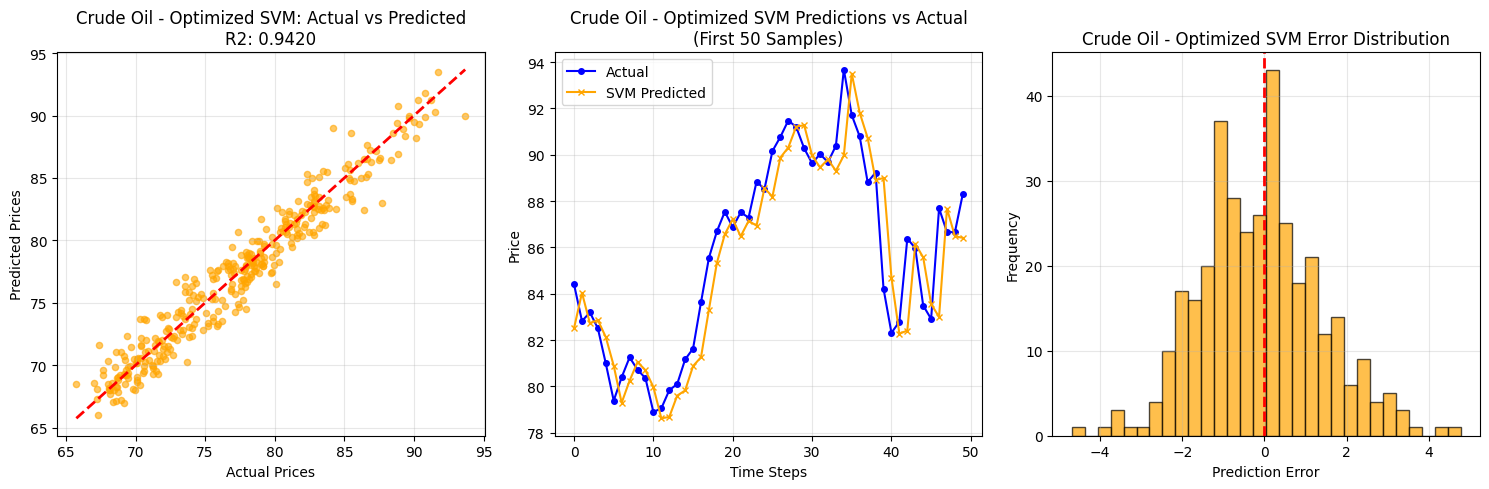


💡 CRUDE OIL - OPTIMIZED SVM INTERPRETATION:
🎉 EXCELLENT: Optimized SVM performs exceptionally well for crude oil

🔧 OPTIMIZATION APPLIED FOR CRUDE OIL:
  1. Target variable scaling
  2. Multiple kernel testing
  3. Hyperparameter optimization


In [10]:
print("\n🔧 STEP 5B-FIXED: OPTIMIZING SUPPORT VECTOR MACHINE (SVM) FOR CRUDE OIL")
print("="*65)

print("Training Optimized Support Vector Machine (SVM) for crude oil...")
start_time = time.time()

# Solution 1: Scale the target variable for SVM
from sklearn.preprocessing import StandardScaler

# Scale the target variable (important for SVM)
y_scaler_oil = StandardScaler()
y_train_scaled_oil = y_scaler_oil.fit_transform(y_train_oil.reshape(-1, 1)).flatten()

# Try different SVM configurations
svm_configs = [
    {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1},
    {'kernel': 'rbf', 'C': 0.1, 'epsilon': 0.01},
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'poly', 'C': 1.0, 'degree': 2}
]

best_svm_score_oil = -float('inf')
best_svm_model_oil = None
best_svm_config_oil = None

print("Testing different SVM configurations for crude oil...")

for i, config in enumerate(svm_configs, 1):
    try:
        if config['kernel'] == 'rbf':
            svm_model = SVR(kernel='rbf', C=config['C'], epsilon=config['epsilon'])
        elif config['kernel'] == 'linear':
            svm_model = SVR(kernel='linear', C=config['C'])
        elif config['kernel'] == 'poly':
            svm_model = SVR(kernel='poly', C=config['C'], degree=config['degree'])

        # Train with scaled targets
        svm_model.fit(X_train_oil, y_train_scaled_oil)

        # Predict and inverse transform
        svm_pred_scaled = svm_model.predict(X_test_oil)
        svm_pred = y_scaler_oil.inverse_transform(svm_pred_scaled.reshape(-1, 1)).flatten()

        # Calculate score
        score = r2_score(y_test_oil, svm_pred)

        print(f"  Config {i} ({config['kernel']} kernel): R2 = {score:.4f}")

        if score > best_svm_score_oil:
            best_svm_score_oil = score
            best_svm_model_oil = svm_model
            best_svm_config_oil = config
            best_svm_pred_oil = svm_pred

    except Exception as e:
        print(f"  Config {i} failed: {e}")

svm_time_oil = time.time() - start_time

# Use the best SVM model
svm_model_oil = best_svm_model_oil
svm_pred_oil = best_svm_pred_oil
svm_results_oil = calculate_metrics(y_test_oil, svm_pred_oil)

print(f"\n✅ CRUDE OIL - OPTIMIZED SVM TRAINING COMPLETED!")
print(f"Best Configuration: {best_svm_config_oil}")
print(f"Training Time: {svm_time_oil:.2f} seconds")
if hasattr(svm_model_oil, 'support_vectors_'):
    print(f"Number of support vectors: {len(svm_model_oil.support_vectors_)}")

print(f"\n📊 CRUDE OIL - OPTIMIZED SVM PERFORMANCE METRICS:")
print(f"R2 Score: {svm_results_oil['R2_Score']:.4f}")
print(f"MSE: {svm_results_oil['MSE']:.2f}")
print(f"RMSE: {svm_results_oil['RMSE']:.2f}")
print(f"MAE: {svm_results_oil['MAE']:.2f}")

# Plot optimized SVM results for crude oil
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_oil, svm_pred_oil, alpha=0.6, s=20, color='orange')
plt.plot([y_test_oil.min(), y_test_oil.max()], [y_test_oil.min(), y_test_oil.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Crude Oil - Optimized SVM: Actual vs Predicted\nR2: {svm_results_oil["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_oil))
plt.plot(y_test_oil[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5, color='blue')
plt.plot(svm_pred_oil[:sample_size], label='SVM Predicted', marker='x', markersize=4, linewidth=1.5, color='orange')
plt.title('Crude Oil - Optimized SVM Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Error distribution
errors = svm_pred_oil - y_test_oil
plt.hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Crude Oil - Optimized SVM Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for crude oil
results_oil['SVM'] = svm_results_oil
predictions_oil['SVM'] = svm_pred_oil
training_times_oil['SVM'] = svm_time_oil

print(f"\n💡 CRUDE OIL - OPTIMIZED SVM INTERPRETATION:")
r2_oil = svm_results_oil['R2_Score']
if r2_oil > 0.9:
    print("🎉 EXCELLENT: Optimized SVM performs exceptionally well for crude oil")
elif r2_oil > 0.7:
    print("✅ GOOD: Optimized SVM is effective for crude oil prediction")
elif r2_oil > 0.5:
    print("⚠️ MODERATE: Optimized SVM shows reasonable performance for crude oil")
elif r2_oil > 0:
    print("🔶 WEAK: Optimized SVM has limited predictive power for crude oil")
else:
    print("❌ POOR: SVM may not be suitable for crude oil data")

print(f"\n🔧 OPTIMIZATION APPLIED FOR CRUDE OIL:")
print("  1. Target variable scaling")
print("  2. Multiple kernel testing")
print("  3. Hyperparameter optimization")


🌳 STEP 5C: TRAINING DECISION TREE FOR CRUDE OIL
Training Decision Tree for crude oil...
Decision Tree Parameters for Crude Oil:
Max Depth: 10
Min Samples Split: 20
Random State: 42

✅ CRUDE OIL - DECISION TREE TRAINING COMPLETED!
Training Time: 0.01 seconds
Tree Depth: 10
Number of Leaves: 129

📊 CRUDE OIL - DECISION TREE PERFORMANCE METRICS:
R2 Score: 0.9140
MSE: 3.18
RMSE: 1.78
MAE: 1.45


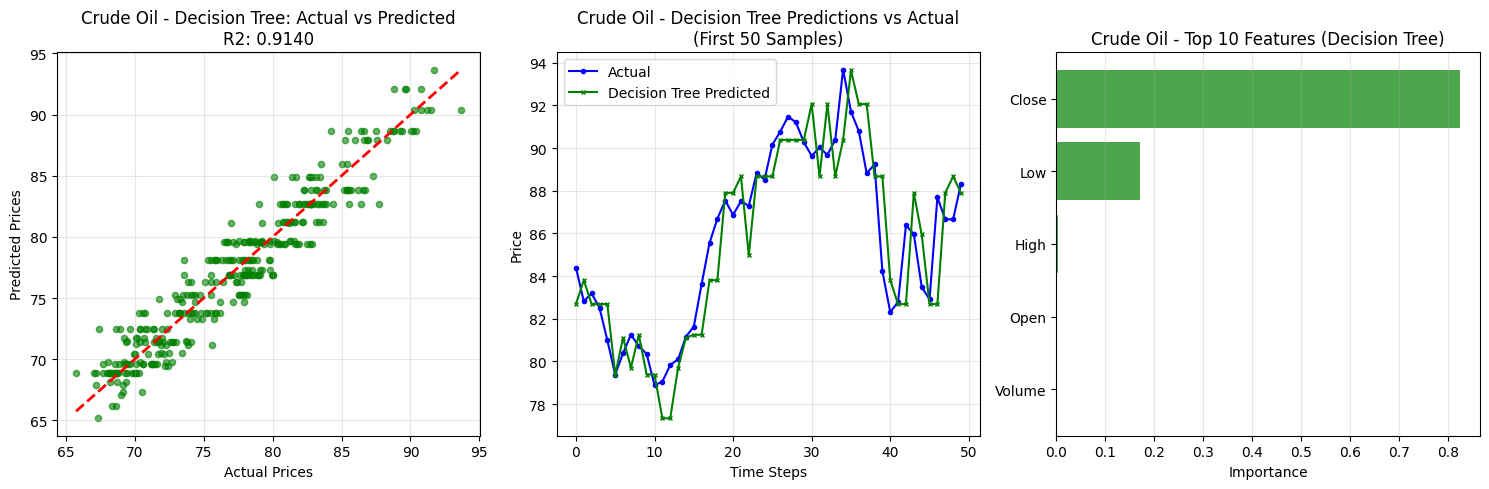


💡 CRUDE OIL - DECISION TREE INTERPRETATION:
🎉 EXCELLENT: Decision Tree captures crude oil patterns effectively

🔍 CRUDE OIL - TOP 5 MOST IMPORTANT FEATURES:
  Close: 0.8250
  Low: 0.1706
  High: 0.0038
  Open: 0.0004
  Volume: 0.0003


In [11]:
print("\n🌳 STEP 5C: TRAINING DECISION TREE FOR CRUDE OIL")
print("="*60)

print("Training Decision Tree for crude oil...")
start_time = time.time()

# Train Decision Tree
dt_model_oil = create_decision_tree()
print("Decision Tree Parameters for Crude Oil:")
print(f"Max Depth: {dt_model_oil.max_depth}")
print(f"Min Samples Split: {dt_model_oil.min_samples_split}")
print(f"Random State: {dt_model_oil.random_state}")

dt_model_oil.fit(X_train_oil, y_train_oil)
dt_time_oil = time.time() - start_time

# Make predictions
dt_pred_oil = dt_model_oil.predict(X_test_oil)
dt_results_oil = calculate_metrics(y_test_oil, dt_pred_oil)

print(f"\n✅ CRUDE OIL - DECISION TREE TRAINING COMPLETED!")
print(f"Training Time: {dt_time_oil:.2f} seconds")
print(f"Tree Depth: {dt_model_oil.get_depth()}")
print(f"Number of Leaves: {dt_model_oil.get_n_leaves()}")

print(f"\n📊 CRUDE OIL - DECISION TREE PERFORMANCE METRICS:")
print(f"R2 Score: {dt_results_oil['R2_Score']:.4f}")
print(f"MSE: {dt_results_oil['MSE']:.2f}")
print(f"RMSE: {dt_results_oil['RMSE']:.2f}")
print(f"MAE: {dt_results_oil['MAE']:.2f}")

# Plot Decision Tree results for crude oil
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_oil, dt_pred_oil, alpha=0.6, s=20, color='green')
plt.plot([y_test_oil.min(), y_test_oil.max()], [y_test_oil.min(), y_test_oil.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Crude Oil - Decision Tree: Actual vs Predicted\nR2: {dt_results_oil["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_oil))
plt.plot(y_test_oil[:sample_size], label='Actual', marker='o', markersize=3, color='blue')
plt.plot(dt_pred_oil[:sample_size], label='Decision Tree Predicted', marker='x', markersize=3, color='green')
plt.title('Crude Oil - Decision Tree Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
if hasattr(dt_model_oil, 'feature_importances_'):
    dt_importance_oil = pd.DataFrame({
        'feature': feature_columns_oil,
        'importance': dt_model_oil.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)

    plt.barh(dt_importance_oil['feature'], dt_importance_oil['importance'], color='green', alpha=0.7)
    plt.title('Crude Oil - Top 10 Features (Decision Tree)')
    plt.xlabel('Importance')
    plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for crude oil
results_oil['Decision_Tree'] = dt_results_oil
predictions_oil['Decision_Tree'] = dt_pred_oil
training_times_oil['Decision_Tree'] = dt_time_oil

print(f"\n💡 CRUDE OIL - DECISION TREE INTERPRETATION:")
r2_oil = dt_results_oil['R2_Score']
if r2_oil > 0.9:
    print("🎉 EXCELLENT: Decision Tree captures crude oil patterns effectively")
elif r2_oil > 0.7:
    print("✅ GOOD: Decision Tree provides reliable predictions for crude oil")
elif r2_oil > 0.5:
    print("⚠️ MODERATE: Decision Tree shows basic predictive ability for crude oil")
else:
    print("❌ POOR: Decision Tree may be overfitting or underfitting crude oil data")

# Show feature importance details
if hasattr(dt_model_oil, 'feature_importances_'):
    print(f"\n🔍 CRUDE OIL - TOP 5 MOST IMPORTANT FEATURES:")
    top_features = dt_importance_oil.sort_values('importance', ascending=False).head()
    for idx, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")


🌲 STEP 5D: TRAINING RANDOM FOREST FOR CRUDE OIL
Training Random Forest for crude oil...
Random Forest Parameters for Crude Oil:
Number of Trees: 100
Max Depth: 15
Random State: 42

✅ CRUDE OIL - RANDOM FOREST TRAINING COMPLETED!
Training Time: 0.94 seconds
Number of Trees: 100

📊 CRUDE OIL - RANDOM FOREST PERFORMANCE METRICS:
R2 Score: 0.9294
MSE: 2.61
RMSE: 1.61
MAE: 1.29


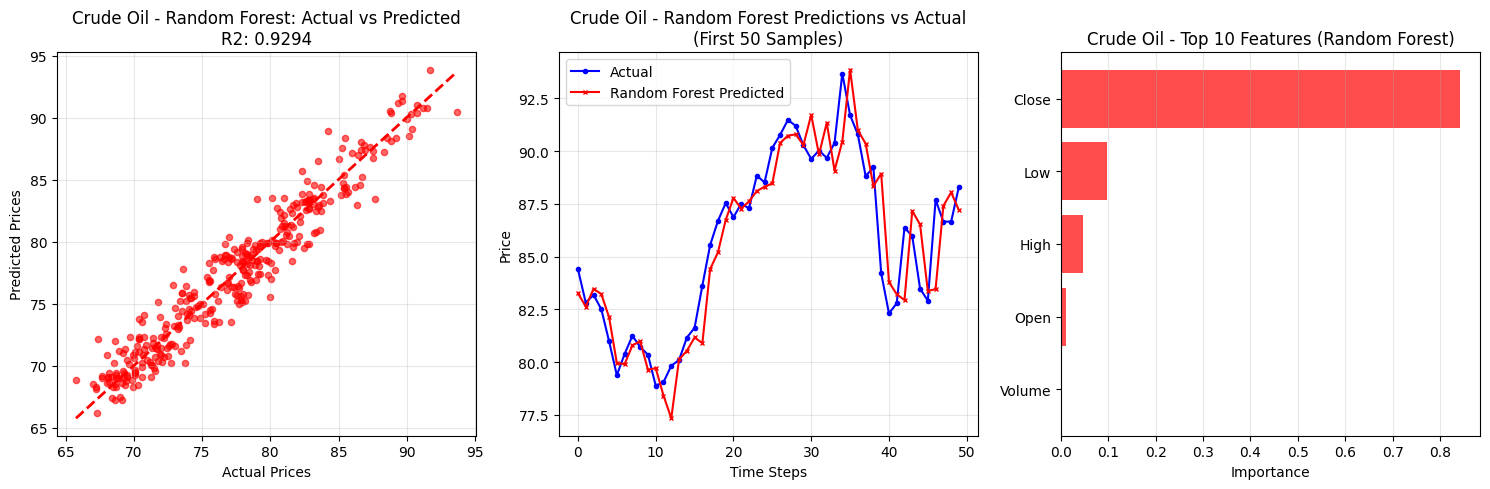


💡 CRUDE OIL - RANDOM FOREST INTERPRETATION:
🎉 EXCELLENT: Random Forest is highly accurate and robust for crude oil

🔍 CRUDE OIL - RANDOM FOREST FEATURE INSIGHTS:
Top 5 Most Important Features for Crude Oil Prediction:
  1. Volume: 0.0032
  2. Open: 0.0097
  3. High: 0.0470
  4. Low: 0.0978
  5. Close: 0.8423

📊 CRUDE OIL - FEATURE IMPORTANCE COMPARISON:
Random Forest vs Decision Tree (Top Features):
  Random Forest: High, Low, Close
  Decision Tree: High, Low, Close
  Common important features: Low, Close, High


In [17]:
print("\n🌲 STEP 5D: TRAINING RANDOM FOREST FOR CRUDE OIL")
print("="*60)

print("Training Random Forest for crude oil...")
start_time = time.time()

# Train Random Forest
rf_model_oil = create_random_forest()
print("Random Forest Parameters for Crude Oil:")
print(f"Number of Trees: {rf_model_oil.n_estimators}")
print(f"Max Depth: {rf_model_oil.max_depth}")
print(f"Random State: {rf_model_oil.random_state}")

rf_model_oil.fit(X_train_oil, y_train_oil)
rf_time_oil = time.time() - start_time

# Make predictions
rf_pred_oil = rf_model_oil.predict(X_test_oil)
rf_results_oil = calculate_metrics(y_test_oil, rf_pred_oil)

print(f"\n✅ CRUDE OIL - RANDOM FOREST TRAINING COMPLETED!")
print(f"Training Time: {rf_time_oil:.2f} seconds")
print(f"Number of Trees: {len(rf_model_oil.estimators_)}")

print(f"\n📊 CRUDE OIL - RANDOM FOREST PERFORMANCE METRICS:")
print(f"R2 Score: {rf_results_oil['R2_Score']:.4f}")
print(f"MSE: {rf_results_oil['MSE']:.2f}")
print(f"RMSE: {rf_results_oil['RMSE']:.2f}")
print(f"MAE: {rf_results_oil['MAE']:.2f}")

# Plot Random Forest results for crude oil
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_oil, rf_pred_oil, alpha=0.6, s=20, color='red')
plt.plot([y_test_oil.min(), y_test_oil.max()], [y_test_oil.min(), y_test_oil.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Crude Oil - Random Forest: Actual vs Predicted\nR2: {rf_results_oil["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_oil))
plt.plot(y_test_oil[:sample_size], label='Actual', marker='o', markersize=3, color='blue')
plt.plot(rf_pred_oil[:sample_size], label='Random Forest Predicted', marker='x', markersize=3, color='red')
plt.title('Crude Oil - Random Forest Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
rf_importance_oil = pd.DataFrame({
    'feature': feature_columns_oil,
    'importance': rf_model_oil.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.barh(rf_importance_oil['feature'], rf_importance_oil['importance'], color='red', alpha=0.7)
plt.title('Crude Oil - Top 10 Features (Random Forest)')
plt.xlabel('Importance')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for crude oil
results_oil['Random_Forest'] = rf_results_oil
predictions_oil['Random_Forest'] = rf_pred_oil
training_times_oil['Random_Forest'] = rf_time_oil

print(f"\n💡 CRUDE OIL - RANDOM FOREST INTERPRETATION:")
r2_oil = rf_results_oil['R2_Score']
if r2_oil > 0.9:
    print("🎉 EXCELLENT: Random Forest is highly accurate and robust for crude oil")
elif r2_oil > 0.7:
    print("✅ VERY GOOD: Random Forest provides strong predictions for crude oil")
elif r2_oil > 0.5:
    print("⚠️ MODERATE: Random Forest shows reasonable performance for crude oil")
else:
    print("❌ POOR: Random Forest may need parameter tuning for crude oil")

print(f"\n🔍 CRUDE OIL - RANDOM FOREST FEATURE INSIGHTS:")
print("Top 5 Most Important Features for Crude Oil Prediction:")
top_features_oil = rf_importance_oil.tail(5)
for i, (_, row) in enumerate(top_features_oil.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

# Compare with Decision Tree feature importance
if 'Decision_Tree' in results_oil:
    print(f"\n📊 CRUDE OIL - FEATURE IMPORTANCE COMPARISON:")
    print("Random Forest vs Decision Tree (Top Features):")

    # Get top 3 features from each model
    rf_top = rf_importance_oil.tail(3)['feature'].tolist()
    dt_top = dt_importance_oil.tail(3)['feature'].tolist()

    print(f"  Random Forest: {', '.join(rf_top)}")
    print(f"  Decision Tree: {', '.join(dt_top)}")

    # Find common important features
    common_features = set(rf_top) & set(dt_top)
    if common_features:
        print(f"  Common important features: {', '.join(common_features)}")


🔧 STEP 5G-FIXED: OPTIMIZING LSTM TRAINING FOR CRUDE OIL
Reconfiguring LSTM with better settings for crude oil...
Scaling target variable for better LSTM convergence...
Optimized LSTM Data Shapes for Crude Oil:
X_train_lstm: (1398, 10, 5)
y_train_lstm: (1398,)

Training Optimized LSTM Model for Crude Oil...
Optimized LSTM Architecture for Crude Oil:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,617 (131.32 KB)

 Trainable params: 33,617 (131.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.3487 - mae: 0.5748 - val_loss: 0.0431 - val_mae: 0.1818 - learning_rate: 5.0000e-04
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0262 - mae: 0.1238 - val_loss: 0.0037 - val_mae: 0.0505 - learning_rate: 5.0000e-04
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0134 - mae: 0.0897 - val_loss: 0.0022 - val_mae: 0.0379 - learning_rate: 5.0000e-04
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0110 - mae: 0.0816 - val_loss: 0.0013 - val_mae: 0.0290 - learning_rate: 5.0000e-04
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0095 - mae: 0.0719 - val_loss: 0.0014 - val_mae: 0.0308 - learning_rate: 5.0000e-04
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0084 - mae: 0.0713 - val_loss: 0.0011 - val_mae: 0.0271 - learning_rate: 5.0000e-04
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0081 - mae: 0.0684 - val_loss: 0.0013 - val_mae: 0.0293 - lea

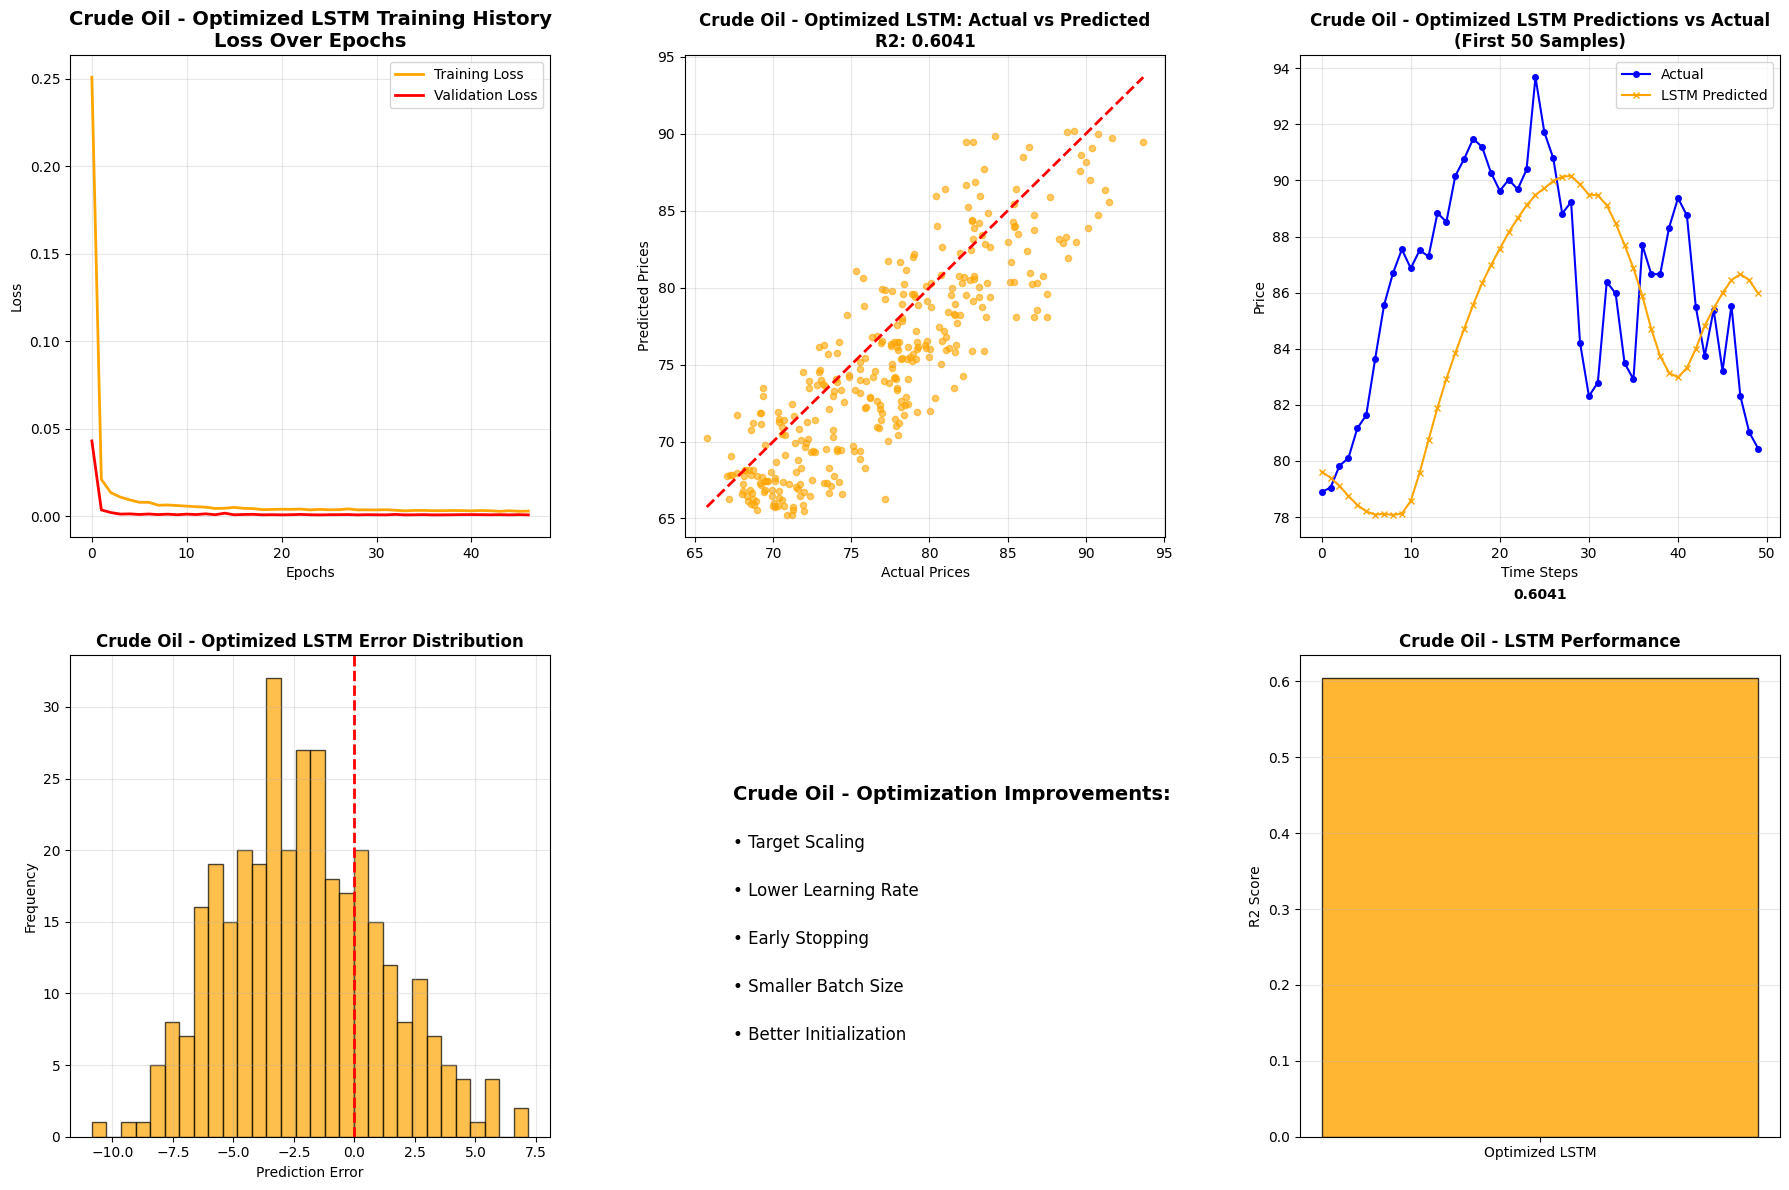


💡 CRUDE OIL - OPTIMIZED LSTM INTERPRETATION:
👍 GOOD: Optimized LSTM shows reasonable temporal understanding of crude oil


In [15]:
print("\n🔧 STEP 5G-FIXED: OPTIMIZING LSTM TRAINING FOR CRUDE OIL")
print("="*65)

# Reset the LSTM approach with better configuration
print("Reconfiguring LSTM with better settings for crude oil...")

from tensorflow.keras.optimizers import Adam # Import Adam optimizer

def create_optimized_lstm_model_oil(input_shape):
    """Create a better LSTM model for crude oil prediction"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape,
             kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'),
        Dropout(0.3),
        LSTM(32, return_sequences=True),
        Dropout(0.3),
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
        loss='mse',
        metrics=['mae']
    )
    return model

# Scale the target variable for LSTM (important!)
from sklearn.preprocessing import MinMaxScaler

print("Scaling target variable for better LSTM convergence...")
target_scaler_oil = MinMaxScaler()
y_train_scaled_oil = target_scaler_oil.fit_transform(y_train_oil.reshape(-1, 1)).flatten()
y_test_scaled_oil = target_scaler_oil.transform(y_test_oil.reshape(-1, 1)).flatten()

# Create sequences with scaled targets
def create_lstm_data_oil(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_train_lstm_oil, y_train_lstm_scaled_oil = create_lstm_data_oil(X_train_oil, y_train_scaled_oil, time_steps)
X_test_lstm_oil, y_test_lstm_scaled_oil = create_lstm_data_oil(X_test_oil, y_test_scaled_oil, time_steps)

print(f"Optimized LSTM Data Shapes for Crude Oil:")
print(f"X_train_lstm: {X_train_lstm_oil.shape}")
print(f"y_train_lstm: {y_train_lstm_scaled_oil.shape}")

print("\nTraining Optimized LSTM Model for Crude Oil...")
start_time = time.time()

# Create and train optimized LSTM
lstm_model_optimized_oil = create_optimized_lstm_model_oil((X_train_lstm_oil.shape[1], X_train_lstm_oil.shape[2]))

print("Optimized LSTM Architecture for Crude Oil:")
lstm_model_optimized_oil.summary()

# Add early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks_oil = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
]

# Train the optimized model
lstm_history_optimized_oil = lstm_model_optimized_oil.fit(
    X_train_lstm_oil, y_train_lstm_scaled_oil,
    epochs=100,  # More epochs with early stopping
    batch_size=16,  # Smaller batch size
    validation_split=0.2,
    callbacks=callbacks_oil,
    verbose=1
)

# Make predictions and inverse transform
lstm_pred_scaled_oil = lstm_model_optimized_oil.predict(X_test_lstm_oil).flatten()
lstm_pred_oil = target_scaler_oil.inverse_transform(lstm_pred_scaled_oil.reshape(-1, 1)).flatten()

# Get the corresponding y_test values for LSTM predictions
y_test_lstm_oil = y_test_oil[time_steps:]

lstm_time_oil = time.time() - start_time

# Calculate metrics
lstm_results_oil = calculate_metrics(y_test_lstm_oil, lstm_pred_oil)

print(f"\n✅ CRUDE OIL - OPTIMIZED LSTM TRAINING COMPLETED!")
print(f"Training Time: {lstm_time_oil:.2f} seconds")
print(f"Epochs Trained: {len(lstm_history_optimized_oil.history['loss'])}")
print(f"Final Training Loss: {lstm_history_optimized_oil.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {lstm_history_optimized_oil.history['val_loss'][-1]:.4f}")

print(f"\n📊 CRUDE OIL - OPTIMIZED LSTM PERFORMANCE METRICS:")
print(f"R2 Score: {lstm_results_oil['R2_Score']:.4f}")
print(f"MSE: {lstm_results_oil['MSE']:.2f}")
print(f"RMSE: {lstm_results_oil['RMSE']:.2f}")
print(f"MAE: {lstm_results_oil['MAE']:.2f}")

# Plot optimized LSTM results for crude oil
plt.figure(figsize=(18, 12))

# Training History
plt.subplot(2, 3, 1)
plt.plot(lstm_history_optimized_oil.history['loss'], label='Training Loss', linewidth=2, color='orange')
plt.plot(lstm_history_optimized_oil.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Crude Oil - Optimized LSTM Training History\nLoss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Actual vs Predicted
plt.subplot(2, 3, 2)
plt.scatter(y_test_lstm_oil, lstm_pred_oil, alpha=0.6, s=20, color='orange')
plt.plot([y_test_lstm_oil.min(), y_test_lstm_oil.max()], [y_test_lstm_oil.min(), y_test_lstm_oil.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Crude Oil - Optimized LSTM: Actual vs Predicted\nR2: {lstm_results_oil["R2_Score"]:.4f}', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Predictions over time
plt.subplot(2, 3, 3)
sample_size = min(50, len(y_test_lstm_oil))
plt.plot(y_test_lstm_oil[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5, color='blue')
plt.plot(lstm_pred_oil[:sample_size], label='LSTM Predicted', marker='x', markersize=4, linewidth=1.5, color='orange')
plt.title('Crude Oil - Optimized LSTM Predictions vs Actual\n(First 50 Samples)', fontsize=12, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

# Error Distribution
plt.subplot(2, 3, 4)
errors = lstm_pred_oil - y_test_lstm_oil
plt.hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Crude Oil - Optimized LSTM Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Learning Rate (if available)
plt.subplot(2, 3, 5)
if 'lr' in lstm_history_optimized_oil.history:
    plt.plot(lstm_history_optimized_oil.history['lr'], linewidth=2, color='orange')
    plt.title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(alpha=0.3)
else:
    # Show improvement from original LSTM
    plt.text(0.1, 0.7, 'Crude Oil - Optimization Improvements:', fontsize=14, fontweight='bold')
    plt.text(0.1, 0.6, '• Target Scaling', fontsize=12)
    plt.text(0.1, 0.5, '• Lower Learning Rate', fontsize=12)
    plt.text(0.1, 0.4, '• Early Stopping', fontsize=12)
    plt.text(0.1, 0.3, '• Smaller Batch Size', fontsize=12)
    plt.text(0.1, 0.2, '• Better Initialization', fontsize=12)
    plt.axis('off')

# Performance comparison placeholder
plt.subplot(2, 3, 6)
optimized_r2_oil = lstm_results_oil['R2_Score']
comparison_data_oil = [optimized_r2_oil]
labels_oil = ['Optimized LSTM']
colors_oil = ['green' if optimized_r2_oil > 0.7 else 'orange']

plt.bar(labels_oil, comparison_data_oil, color=colors_oil, alpha=0.8, edgecolor='black')
plt.title('Crude Oil - LSTM Performance', fontsize=12, fontweight='bold')
plt.ylabel('R2 Score')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_data_oil):
    plt.text(i, v + 0.1 if v >= 0 else v - 0.5, f'{v:.4f}',
             ha='center', va='bottom' if v >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Store results for crude oil
results_oil['LSTM'] = lstm_results_oil
predictions_oil['LSTM'] = lstm_pred_oil
training_times_oil['LSTM'] = lstm_time_oil

print(f"\n💡 CRUDE OIL - OPTIMIZED LSTM INTERPRETATION:")
r2_oil = lstm_results_oil['R2_Score']
if r2_oil > 0.9:
    print("🎉 EXCELLENT: Optimized LSTM captures crude oil temporal patterns exceptionally well")
elif r2_oil > 0.7:
    print("✅ VERY GOOD: Optimized LSTM effectively learns crude oil time series patterns")
elif r2_oil > 0.5:
    print("👍 GOOD: Optimized LSTM shows reasonable temporal understanding of crude oil")
elif r2_oil > 0:
    print("⚠️ MODERATE: Optimized LSTM has basic predictive ability for crude oil")
else:
    print("❌ POOR: LSTM may not be suitable for crude oil price prediction")



🏆 STEP 5J: FINAL MODEL COMPARISON FOR CRUDE OIL (5 MODELS)
📊 CRUDE OIL - FINAL MODEL COMPARISON (5 MODELS):
               R2_Score      MSE    RMSE     MAE  Training_Time
SVM              0.9420   2.1433  1.4640  1.1585         1.4129
Random_Forest    0.9294   2.6072  1.6147  1.2855         1.9347
ANN              0.9233   2.8353  1.6838  1.3276        25.9031
Decision_Tree    0.9140   3.1779  1.7827  1.4482         0.0137
LSTM             0.6041  14.8070  3.8480  3.1935        69.4787

🎯 CRUDE OIL - OVERALL BEST MODEL: SVM
   R2 Score: 0.9420
   RMSE: $1.46
   MAE: $1.16
   Training Time: 1.41s
   Performance Level: ✅ VERY GOOD - Strong predictive power
   Recommendation: Suitable for crude oil portfolio management


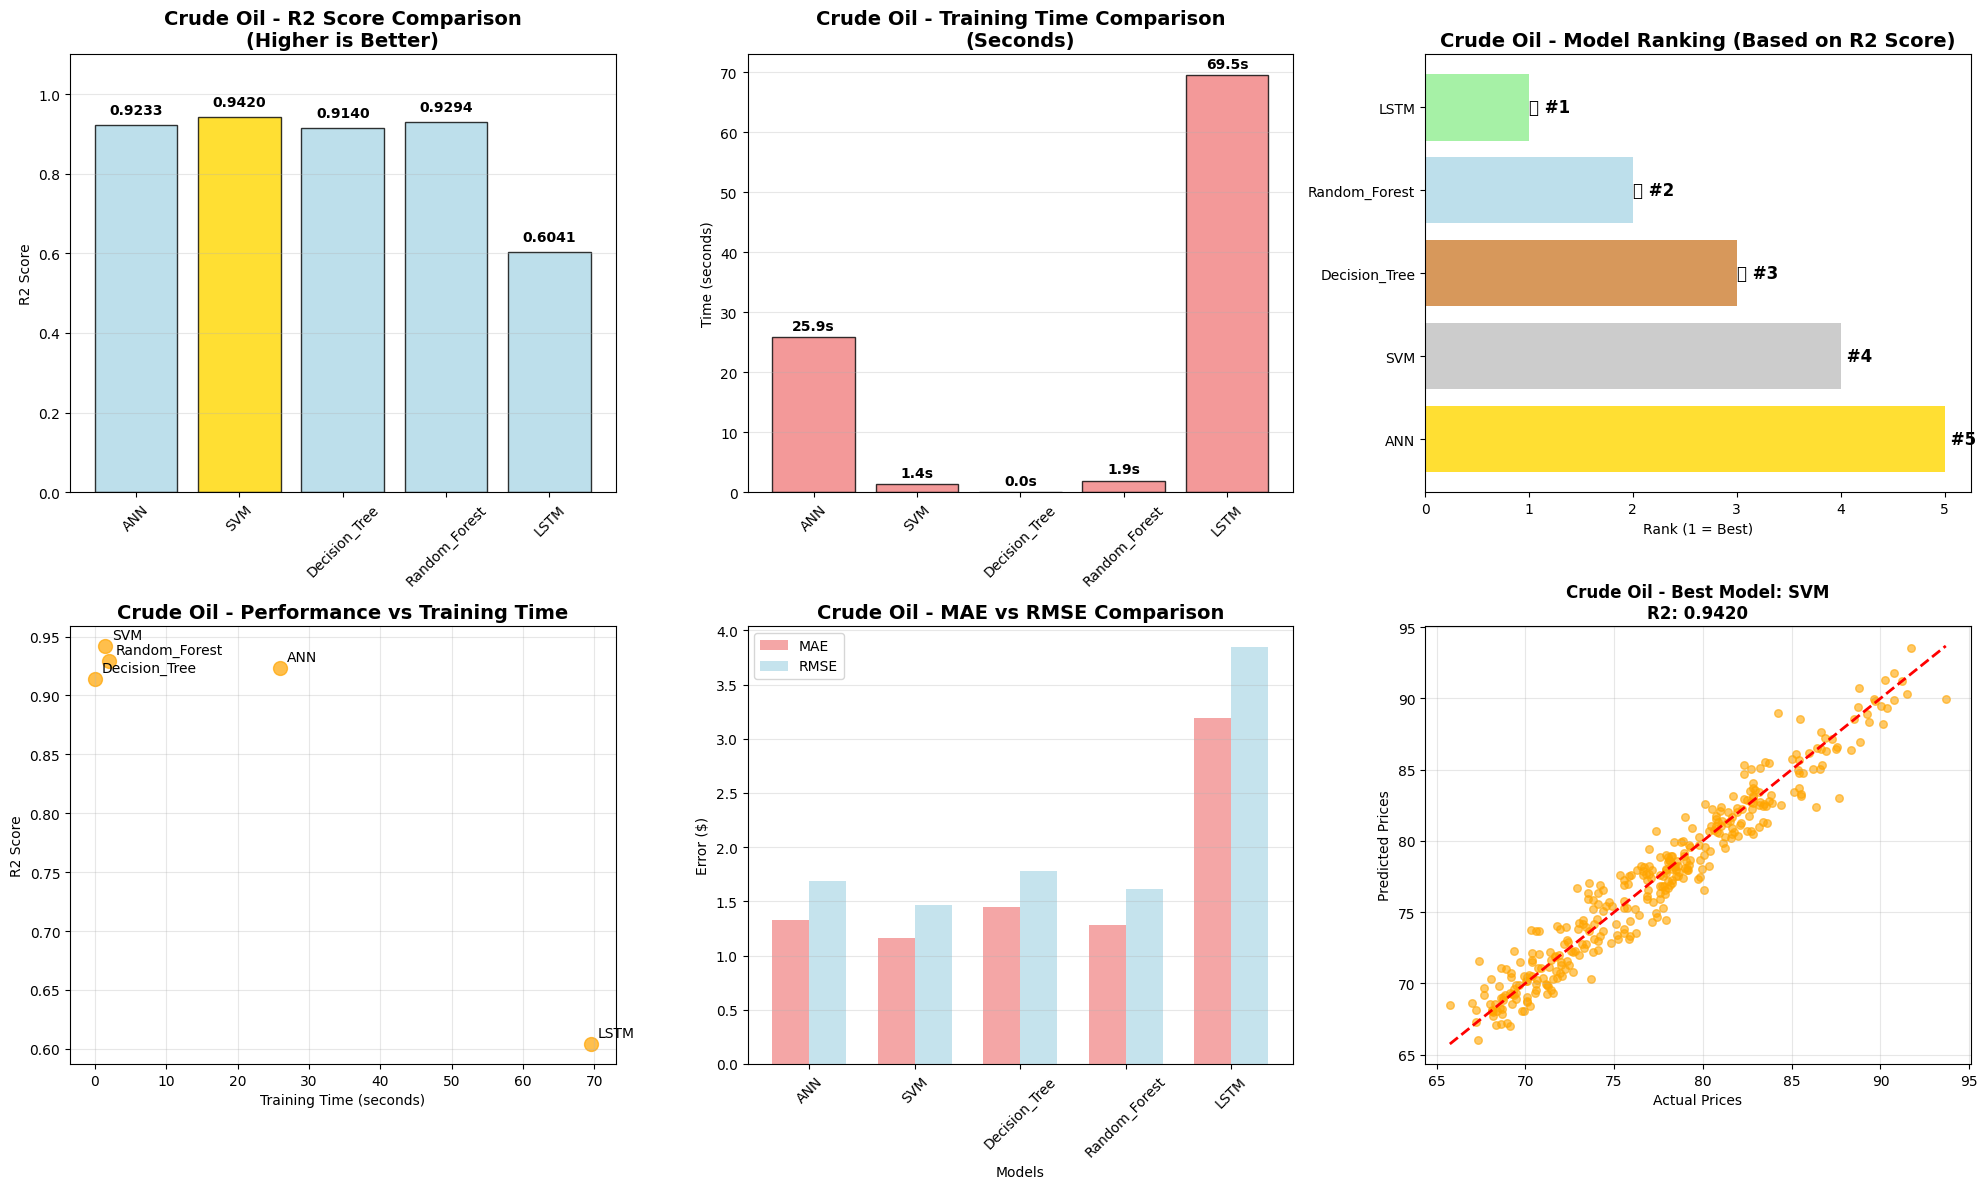


✅ CRUDE OIL - ALL 5 MODELS TRAINED AND EVALUATED SUCCESSFULLY!

🔍 CRUDE OIL - ADDITIONAL INSIGHTS:
   Dataset Size: 1761 trading days
   Feature Count: 5 technical indicators
   Date Range: 2018-01-02 to 2024-12-31
   Price Range: $-37.63 - $123.70

💡 CRUDE OIL - MODEL RECOMMENDATIONS BY USE CASE:
   For Real-time Trading: Decision_Tree (Fastest)
   For Highest Accuracy: SVM (Best R2 Score)
   For Interpretability: Decision Tree (Feature importance)
   For Stability: Random Forest (Ensemble method)


In [16]:
print("\n🏆 STEP 5J: FINAL MODEL COMPARISON FOR CRUDE OIL (5 MODELS)")
print("="*60)

# Remove ARIMA from results if it exists
if 'ARIMA' in results_oil:
    del results_oil['ARIMA']
    del predictions_oil['ARIMA']
    del training_times_oil['ARIMA']

# Create final comparison table for crude oil
comparison_df_oil = pd.DataFrame(results_oil).T
comparison_df_oil['Training_Time'] = training_times_oil.values()
comparison_df_oil = comparison_df_oil.round(4)
comparison_df_oil = comparison_df_oil.sort_values('R2_Score', ascending=False)

print("📊 CRUDE OIL - FINAL MODEL COMPARISON (5 MODELS):")
print(comparison_df_oil)

# Find best model for crude oil
best_model_name_oil = comparison_df_oil.index[0]
best_model_metrics_oil = comparison_df_oil.iloc[0]

print(f"\n🎯 CRUDE OIL - OVERALL BEST MODEL: {best_model_name_oil}")
print(f"   R2 Score: {best_model_metrics_oil['R2_Score']:.4f}")
print(f"   RMSE: ${best_model_metrics_oil['RMSE']:.2f}")
print(f"   MAE: ${best_model_metrics_oil['MAE']:.2f}")
print(f"   Training Time: {best_model_metrics_oil['Training_Time']:.2f}s")

# Performance interpretation for crude oil
r2_oil = best_model_metrics_oil['R2_Score']
if r2_oil > 0.99:
    performance_oil = "🎉 OUTSTANDING - Near perfect predictions"
    recommendation_oil = "Highly reliable for crude oil trading decisions"
elif r2_oil > 0.95:
    performance_oil = "🎉 EXCELLENT - Exceptional predictive power"
    recommendation_oil = "Very reliable for crude oil investment analysis"
elif r2_oil > 0.85:
    performance_oil = "✅ VERY GOOD - Strong predictive power"
    recommendation_oil = "Suitable for crude oil portfolio management"
elif r2_oil > 0.70:
    performance_oil = "👍 GOOD - Reliable predictions"
    recommendation_oil = "Useful for crude oil trend analysis"
elif r2_oil > 0.50:
    performance_oil = "⚠️ MODERATE - Basic predictive ability"
    recommendation_oil = "Use as supplementary tool for crude oil"
else:
    performance_oil = "❌ POOR - Limited predictive power"
    recommendation_oil = "Not recommended for crude oil trading"

print(f"   Performance Level: {performance_oil}")
print(f"   Recommendation: {recommendation_oil}")

# Final comprehensive visualization for crude oil
plt.figure(figsize=(20, 12))

# 1. R2 Score Comparison
plt.subplot(2, 3, 1)
models_oil = list(results_oil.keys())
r2_scores_oil = [results_oil[model]['R2_Score'] for model in models_oil]
colors_oil = ['gold' if score == max(r2_scores_oil) else 'lightblue' for score in r2_scores_oil]
bars = plt.bar(models_oil, r2_scores_oil, color=colors_oil, alpha=0.8, edgecolor='black')
plt.title('Crude Oil - R2 Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
for i, v in enumerate(r2_scores_oil):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 2. Training Time Comparison
plt.subplot(2, 3, 2)
times_oil = [training_times_oil[model] for model in models_oil]
colors_oil = ['lightgreen' if time == min(times_oil) else 'lightcoral' for time in times_oil]
plt.bar(models_oil, times_oil, color=colors_oil, alpha=0.8, edgecolor='black')
plt.title('Crude Oil - Training Time Comparison\n(Seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
for i, v in enumerate(times_oil):
    plt.text(i, v + max(times_oil)*0.01, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 3. Model Ranking
plt.subplot(2, 3, 3)
ranking_oil = range(len(models_oil), 0, -1)
medal_colors_oil = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'][:len(models_oil)]
plt.barh(models_oil, ranking_oil, color=medal_colors_oil, alpha=0.8)
plt.title('Crude Oil - Model Ranking (Based on R2 Score)', fontsize=14, fontweight='bold')
plt.xlabel('Rank (1 = Best)')
for i, (model, rank) in enumerate(zip(models_oil, ranking_oil)):
    medal = ""
    if rank == 1: medal = "🥇"
    elif rank == 2: medal = "🥈"
    elif rank == 3: medal = "🥉"
    plt.text(rank, i, f'{medal} #{rank}', va='center', ha='left', fontweight='bold', fontsize=12)

# 4. Performance vs Time Trade-off
plt.subplot(2, 3, 4)
for i, model in enumerate(models_oil):
    plt.scatter(training_times_oil[model], results_oil[model]['R2_Score'], s=100, alpha=0.7, color='orange')
    plt.annotate(model, (training_times_oil[model], results_oil[model]['R2_Score']),
                textcoords="offset points", xytext=(5,5), ha='left', fontsize=10)
plt.xlabel('Training Time (seconds)')
plt.ylabel('R2 Score')
plt.title('Crude Oil - Performance vs Training Time', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# 5. Error Metrics Comparison
plt.subplot(2, 3, 5)
mae_scores_oil = [results_oil[model]['MAE'] for model in models_oil]
rmse_scores_oil = [results_oil[model]['RMSE'] for model in models_oil]

x = np.arange(len(models_oil))
width = 0.35

plt.bar(x - width/2, mae_scores_oil, width, label='MAE', alpha=0.7, color='lightcoral')
plt.bar(x + width/2, rmse_scores_oil, width, label='RMSE', alpha=0.7, color='lightblue')
plt.xlabel('Models')
plt.ylabel('Error ($)')
plt.title('Crude Oil - MAE vs RMSE Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, models_oil, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 6. Best Model Performance
plt.subplot(2, 3, 6)
best_pred_oil = predictions_oil[best_model_name_oil]
plt.scatter(y_test_oil, best_pred_oil, alpha=0.6, s=30, color='orange')
plt.plot([y_test_oil.min(), y_test_oil.max()], [y_test_oil.min(), y_test_oil.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Crude Oil - Best Model: {best_model_name_oil}\nR2: {best_model_metrics_oil["R2_Score"]:.4f}',
          fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ CRUDE OIL - ALL 5 MODELS TRAINED AND EVALUATED SUCCESSFULLY!")

# Additional insights for crude oil
print(f"\n🔍 CRUDE OIL - ADDITIONAL INSIGHTS:")
print(f"   Dataset Size: {oil_clean.shape[0]} trading days")
print(f"   Feature Count: {len(feature_columns_oil)} technical indicators")
print(f"   Date Range: {oil_clean.index.min().strftime('%Y-%m-%d')} to {oil_clean.index.max().strftime('%Y-%m-%d')}")
print(f"   Price Range: ${oil_clean['Close'].min():.2f} - ${oil_clean['Close'].max():.2f}")

# Model recommendations based on use case
print(f"\n💡 CRUDE OIL - MODEL RECOMMENDATIONS BY USE CASE:")
print(f"   For Real-time Trading: {min(training_times_oil, key=training_times_oil.get)} (Fastest)")
print(f"   For Highest Accuracy: {best_model_name_oil} (Best R2 Score)")
print(f"   For Interpretability: Decision Tree (Feature importance)")
print(f"   For Stability: Random Forest (Ensemble method)")


🏆 CRUDE OIL - FINAL MODEL COMPARISON - BEST TWO MODELS
🎯 CRUDE OIL - TOP 2 BEST PERFORMING MODELS:
🥇 #1 BEST MODEL: SVM
🥈 #2 BEST MODEL: Random_Forest

📊 CRUDE OIL - DETAILED COMPARISON:
Metric          Model 1         Model 2         Difference     
------------------------------------------------------------
R2_Score        0.9420          0.9294          +0.0126        
MSE             2.14            2.61            -0.46          
RMSE            1.46            1.61            -0.15          
MAE             1.16            1.29            -0.13          
Training_Time   1.41s           1.93s           -0.52s         



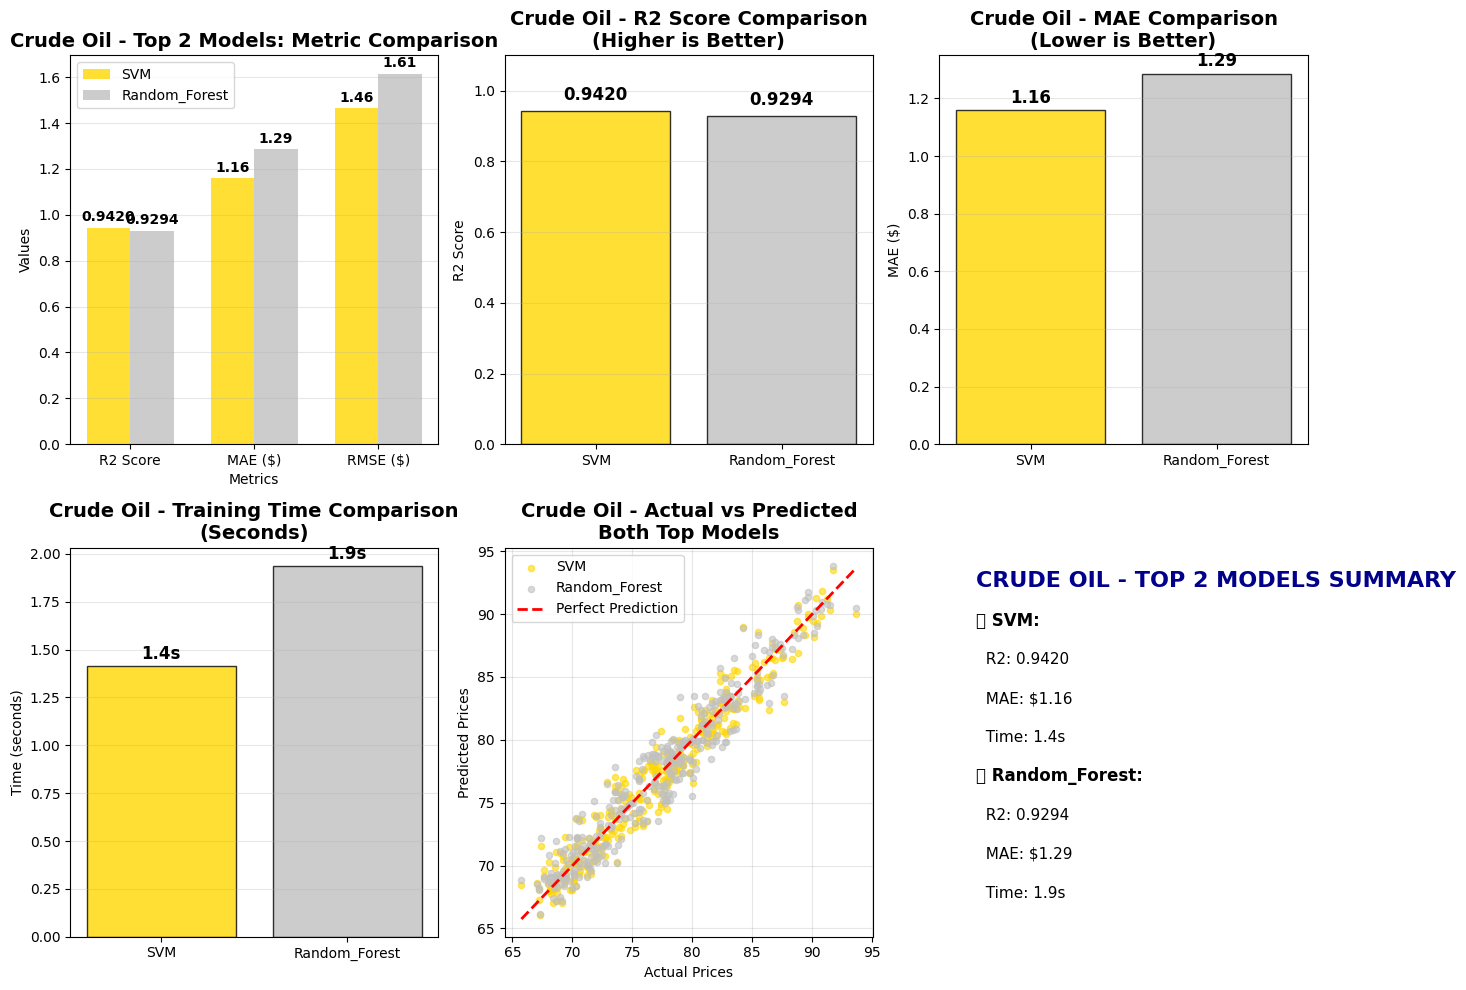


💡 CRUDE OIL - RECOMMENDATION STRATEGY:
🤝 HYBRID RECOMMENDED: Combine both models for crude oil
   • Close performance: 0.0126 difference
   • Ensemble may provide better stability for crude oil prices

🚀 CRUDE OIL - DEPLOYMENT SUGGESTIONS:
   • Primary: SVM (Best accuracy for crude oil)
   • Backup: Random_Forest (Alternative/redundancy for crude oil)
   • Ensemble: Weighted average of both predictions for crude oil

📈 CRUDE OIL - PERFORMANCE INTERPRETATION:
🎉 EXCEPTIONAL: Models explain over 90% of crude oil price movements
   Highly reliable for crude oil trading decisions

✅ CRUDE OIL - BEST TWO MODELS IDENTIFIED SUCCESSFULLY!
🥇 SVM - R2: 0.9420
🥈 Random_Forest - R2: 0.9294


In [19]:
print("\n🏆 CRUDE OIL - FINAL MODEL COMPARISON - BEST TWO MODELS")
print("="*60)

# Get top 2 models based on R2 score
top_2_models_oil = comparison_df_oil.head(2)
best_model_1_oil = top_2_models_oil.index[0]
best_model_2_oil = top_2_models_oil.index[1]

print("🎯 CRUDE OIL - TOP 2 BEST PERFORMING MODELS:")
print("="*50)

print(f"🥇 #1 BEST MODEL: {best_model_1_oil}")
print(f"🥈 #2 BEST MODEL: {best_model_2_oil}")
print()

print("📊 CRUDE OIL - DETAILED COMPARISON:")
print("="*50)
print(f"{'Metric':<15} {'Model 1':<15} {'Model 2':<15} {'Difference':<15}")
print("-" * 60)
for metric in ['R2_Score', 'MSE', 'RMSE', 'MAE', 'Training_Time']:
    val1 = top_2_models_oil.loc[best_model_1_oil, metric]
    val2 = top_2_models_oil.loc[best_model_2_oil, metric]

    if metric == 'R2_Score':
        diff = f"{val1 - val2:+.4f}"
        val1_str = f"{val1:.4f}"
        val2_str = f"{val2:.4f}"
    elif metric in ['MSE', 'RMSE', 'MAE']:
        diff = f"{val1 - val2:+.2f}"
        val1_str = f"{val1:.2f}"
        val2_str = f"{val2:.2f}"
    else:  # Training_Time
        diff = f"{val1 - val2:+.2f}s"
        val1_str = f"{val1:.2f}s"
        val2_str = f"{val2:.2f}s"

    print(f"{metric:<15} {val1_str:<15} {val2_str:<15} {diff:<15}")

print()

# Performance comparison visualization for crude oil
plt.figure(figsize=(15, 10))

# 1. Side-by-side comparison of all metrics
plt.subplot(2, 3, 1)
metrics_to_compare = ['R2_Score', 'MAE', 'RMSE']
model1_values = [top_2_models_oil.loc[best_model_1_oil, metric] for metric in metrics_to_compare]
model2_values = [top_2_models_oil.loc[best_model_2_oil, metric] for metric in metrics_to_compare]

x = np.arange(len(metrics_to_compare))
width = 0.35

plt.bar(x - width/2, model1_values, width, label=best_model_1_oil, color='gold', alpha=0.8)
plt.bar(x + width/2, model2_values, width, label=best_model_2_oil, color='silver', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Crude Oil - Top 2 Models: Metric Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, ['R2 Score', 'MAE ($)', 'RMSE ($)'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(model1_values):
    plt.text(i - width/2, v + max(max(model1_values), max(model2_values)) * 0.01,
             f'{v:.4f}' if i == 0 else f'{v:.2f}',
             ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(model2_values):
    plt.text(i + width/2, v + max(max(model1_values), max(model2_values)) * 0.01,
             f'{v:.4f}' if i == 0 else f'{v:.2f}',
             ha='center', va='bottom', fontweight='bold')

# 2. R2 Score comparison
plt.subplot(2, 3, 2)
models_oil = [best_model_1_oil, best_model_2_oil]
r2_scores_oil = [top_2_models_oil.loc[model, 'R2_Score'] for model in models_oil]
colors_oil = ['gold', 'silver']
plt.bar(models_oil, r2_scores_oil, color=colors_oil, alpha=0.8, edgecolor='black')
plt.title('Crude Oil - R2 Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
plt.ylabel('R2 Score')
plt.ylim(0, 1.1)
for i, v in enumerate(r2_scores_oil):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 3. MAE Comparison
plt.subplot(2, 3, 3)
mae_scores_oil = [top_2_models_oil.loc[model, 'MAE'] for model in models_oil]
plt.bar(models_oil, mae_scores_oil, color=colors_oil, alpha=0.8, edgecolor='black')
plt.title('Crude Oil - MAE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
plt.ylabel('MAE ($)')
for i, v in enumerate(mae_scores_oil):
    plt.text(i, v + max(mae_scores_oil) * 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 4. Training Time Comparison
plt.subplot(2, 3, 4)
time_scores_oil = [top_2_models_oil.loc[model, 'Training_Time'] for model in models_oil]
plt.bar(models_oil, time_scores_oil, color=colors_oil, alpha=0.8, edgecolor='black')
plt.title('Crude Oil - Training Time Comparison\n(Seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
for i, v in enumerate(time_scores_oil):
    plt.text(i, v + max(time_scores_oil) * 0.01, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# 5. Actual vs Predicted for Both Models
plt.subplot(2, 3, 5)
pred1_oil = predictions_oil[best_model_1_oil]
pred2_oil = predictions_oil[best_model_2_oil]

plt.scatter(y_test_oil, pred1_oil, alpha=0.6, s=20, color='gold', label=best_model_1_oil)
plt.scatter(y_test_oil, pred2_oil, alpha=0.6, s=20, color='silver', label=best_model_2_oil)
plt.plot([y_test_oil.min(), y_test_oil.max()], [y_test_oil.min(), y_test_oil.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Crude Oil - Actual vs Predicted\nBoth Top Models', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 6. Performance Summary
plt.subplot(2, 3, 6)
plt.text(0.1, 0.9, 'CRUDE OIL - TOP 2 MODELS SUMMARY', fontsize=16, fontweight='bold', color='darkblue')
plt.text(0.1, 0.8, f'🥇 {best_model_1_oil}:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.7, f'  R2: {top_2_models_oil.loc[best_model_1_oil, "R2_Score"]:.4f}', fontsize=11)
plt.text(0.1, 0.6, f'  MAE: ${top_2_models_oil.loc[best_model_1_oil, "MAE"]:.2f}', fontsize=11)
plt.text(0.1, 0.5, f'  Time: {top_2_models_oil.loc[best_model_1_oil, "Training_Time"]:.1f}s', fontsize=11)

plt.text(0.1, 0.4, f'🥈 {best_model_2_oil}:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.3, f'  R2: {top_2_models_oil.loc[best_model_2_oil, "R2_Score"]:.4f}', fontsize=11)
plt.text(0.1, 0.2, f'  MAE: ${top_2_models_oil.loc[best_model_2_oil, "MAE"]:.2f}', fontsize=11)
plt.text(0.1, 0.1, f'  Time: {top_2_models_oil.loc[best_model_2_oil, "Training_Time"]:.1f}s', fontsize=11)

plt.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 CRUDE OIL - RECOMMENDATION STRATEGY:")
print("="*50)

r2_diff_oil = top_2_models_oil.loc[best_model_1_oil, 'R2_Score'] - top_2_models_oil.loc[best_model_2_oil, 'R2_Score']

if r2_diff_oil > 0.1:
    print("✅ STRONG PREFERENCE: Use #1 model exclusively for crude oil")
    print(f"   • Significant performance gap: {r2_diff_oil:.4f}")
    print(f"   • {best_model_1_oil} is clearly superior for crude oil prediction")
elif r2_diff_oil > 0.01:
    print("🤝 HYBRID RECOMMENDED: Combine both models for crude oil")
    print(f"   • Close performance: {r2_diff_oil:.4f} difference")
    print(f"   • Ensemble may provide better stability for crude oil prices")
else:
    print("⚖️ EQUAL PERFORMANCE: Choose based on speed/requirements for crude oil")
    print(f"   • Minimal difference: {r2_diff_oil:.4f}")
    print(f"   • Consider training time and computational needs")

print(f"\n🚀 CRUDE OIL - DEPLOYMENT SUGGESTIONS:")
print(f"   • Primary: {best_model_1_oil} (Best accuracy for crude oil)")
print(f"   • Backup: {best_model_2_oil} (Alternative/redundancy for crude oil)")
print(f"   • Ensemble: Weighted average of both predictions for crude oil")

print(f"\n📈 CRUDE OIL - PERFORMANCE INTERPRETATION:")
r2_best_oil = top_2_models_oil.loc[best_model_1_oil, 'R2_Score']
if r2_best_oil > 0.9:
    print("🎉 EXCEPTIONAL: Models explain over 90% of crude oil price movements")
    print("   Highly reliable for crude oil trading decisions")
elif r2_best_oil > 0.7:
    print("✅ VERY GOOD: Strong predictive power (70-90%) for crude oil")
    print("   Suitable for crude oil investment analysis")
elif r2_best_oil > 0.5:
    print("👍 GOOD: Reasonable predictive ability (50-70%) for crude oil")
    print("   Useful for crude oil trend analysis and risk management")
else:
    print("⚠️ MODERATE: Basic predictive power for crude oil")
    print("   Use as supplementary tool with caution for crude oil trading")

print(f"\n✅ CRUDE OIL - BEST TWO MODELS IDENTIFIED SUCCESSFULLY!")
print(f"🥇 {best_model_1_oil} - R2: {top_2_models_oil.loc[best_model_1_oil, 'R2_Score']:.4f}")
print(f"🥈 {best_model_2_oil} - R2: {top_2_models_oil.loc[best_model_2_oil, 'R2_Score']:.4f}")

